In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import statsmodels.api as sm
import statsmodels.formula.api as smf
from saturation.utils import *

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.api import add_constant

In [3]:
n_cores = 28

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "500")
         .config("spark.driver.memory", "40g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

25/01/11 17:24:51 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.50.14 instead (on interface enp8s0)
25/01/11 17:24:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/11 17:24:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
base_path = "/data/saturation/thesis_run_20250108/"

colors = ["blue", "black", "r", "orange", "g"]
line_styles = ["-"]
font_size = 24
dpi = 400

configs_df = create_configs_df(
    read_configs(
        base_path,
        spark,
        completed_only=False
    )
)
configs_pdf = configs_df.toPandas()

configs_pdf = configs_pdf[~configs_pdf.simulation_id.isna()].copy()
configs_pdf["rim_erasure_exponent"] = configs_pdf.rim_erasure_method.apply(lambda x: x.get("exponent", -1))
configs_pdf["rim_erasure_radius_ratio"] = configs_pdf.rim_erasure_method.apply(lambda x: x.get("ratio", -1))

In [5]:
configs_dict = dict()
for config_file in glob.glob(f"{base_path}/config/config*.yaml"):
    configs_dict.update(read_config(Path(config_file))["run_configurations"])

In [17]:
df = get_statistics_with_lifespans_for_simulations(
    [2],
    base_path,
    configs_df,
    spark,
    n_samples_per_sim=100000
)
df

,x,y,radius,simulation_id,ntot,nobs,areal_density,slope,mrp,rmult,rim_erasure_method_name,rim_erasure_radius_ratio,rim_erasure_exponent,lifespan
0,528.735657,1843.788818,3.099571,2,369,365,0.004913,-4.0,0.5,1.5,NaN,5.0,0.0,943693
1,2236.169678,657.341797,3.420556,2,595,583,0.007976,-4.0,0.5,1.5,NaN,5.0,0.0,1346123
2,1548.079834,1675.278198,3.215344,2,1782,1253,0.020174,-4.0,0.5,1.5,NaN,5.0,0.0,1610747
3,495.344360,1298.961182,4.892996,2,2124,1320,0.022056,-4.0,0.5,1.5,NaN,5.0,0.0,1766438
4,2122.719971,1802.362183,3.406960,2,3015,1527,0.026654,-4.0,0.5,1.5,NaN,5.0,0.0,515477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1511.969238,1227.414185,3.292271,2,1530323,1822,0.107090,-4.0,0.5,1.5,NaN,5.0,0.0,1594312
99996,1784.452759,1693.837524,3.490415,2,1530495,1832,0.107214,-4.0,0.5,1.5,NaN,5.0,0.0,637074
99997,1151.098877,922.131409,5.097535,2,1530527,1845,0.107495,-4.0,0.5,1.5,NaN,5.0,0.0,4856559
99998,474.328796,2175.465576,8.096049,2,1532573,1863,0.107179,-4.0,0.5,1.5,NaN,5.0,0.0,9831974


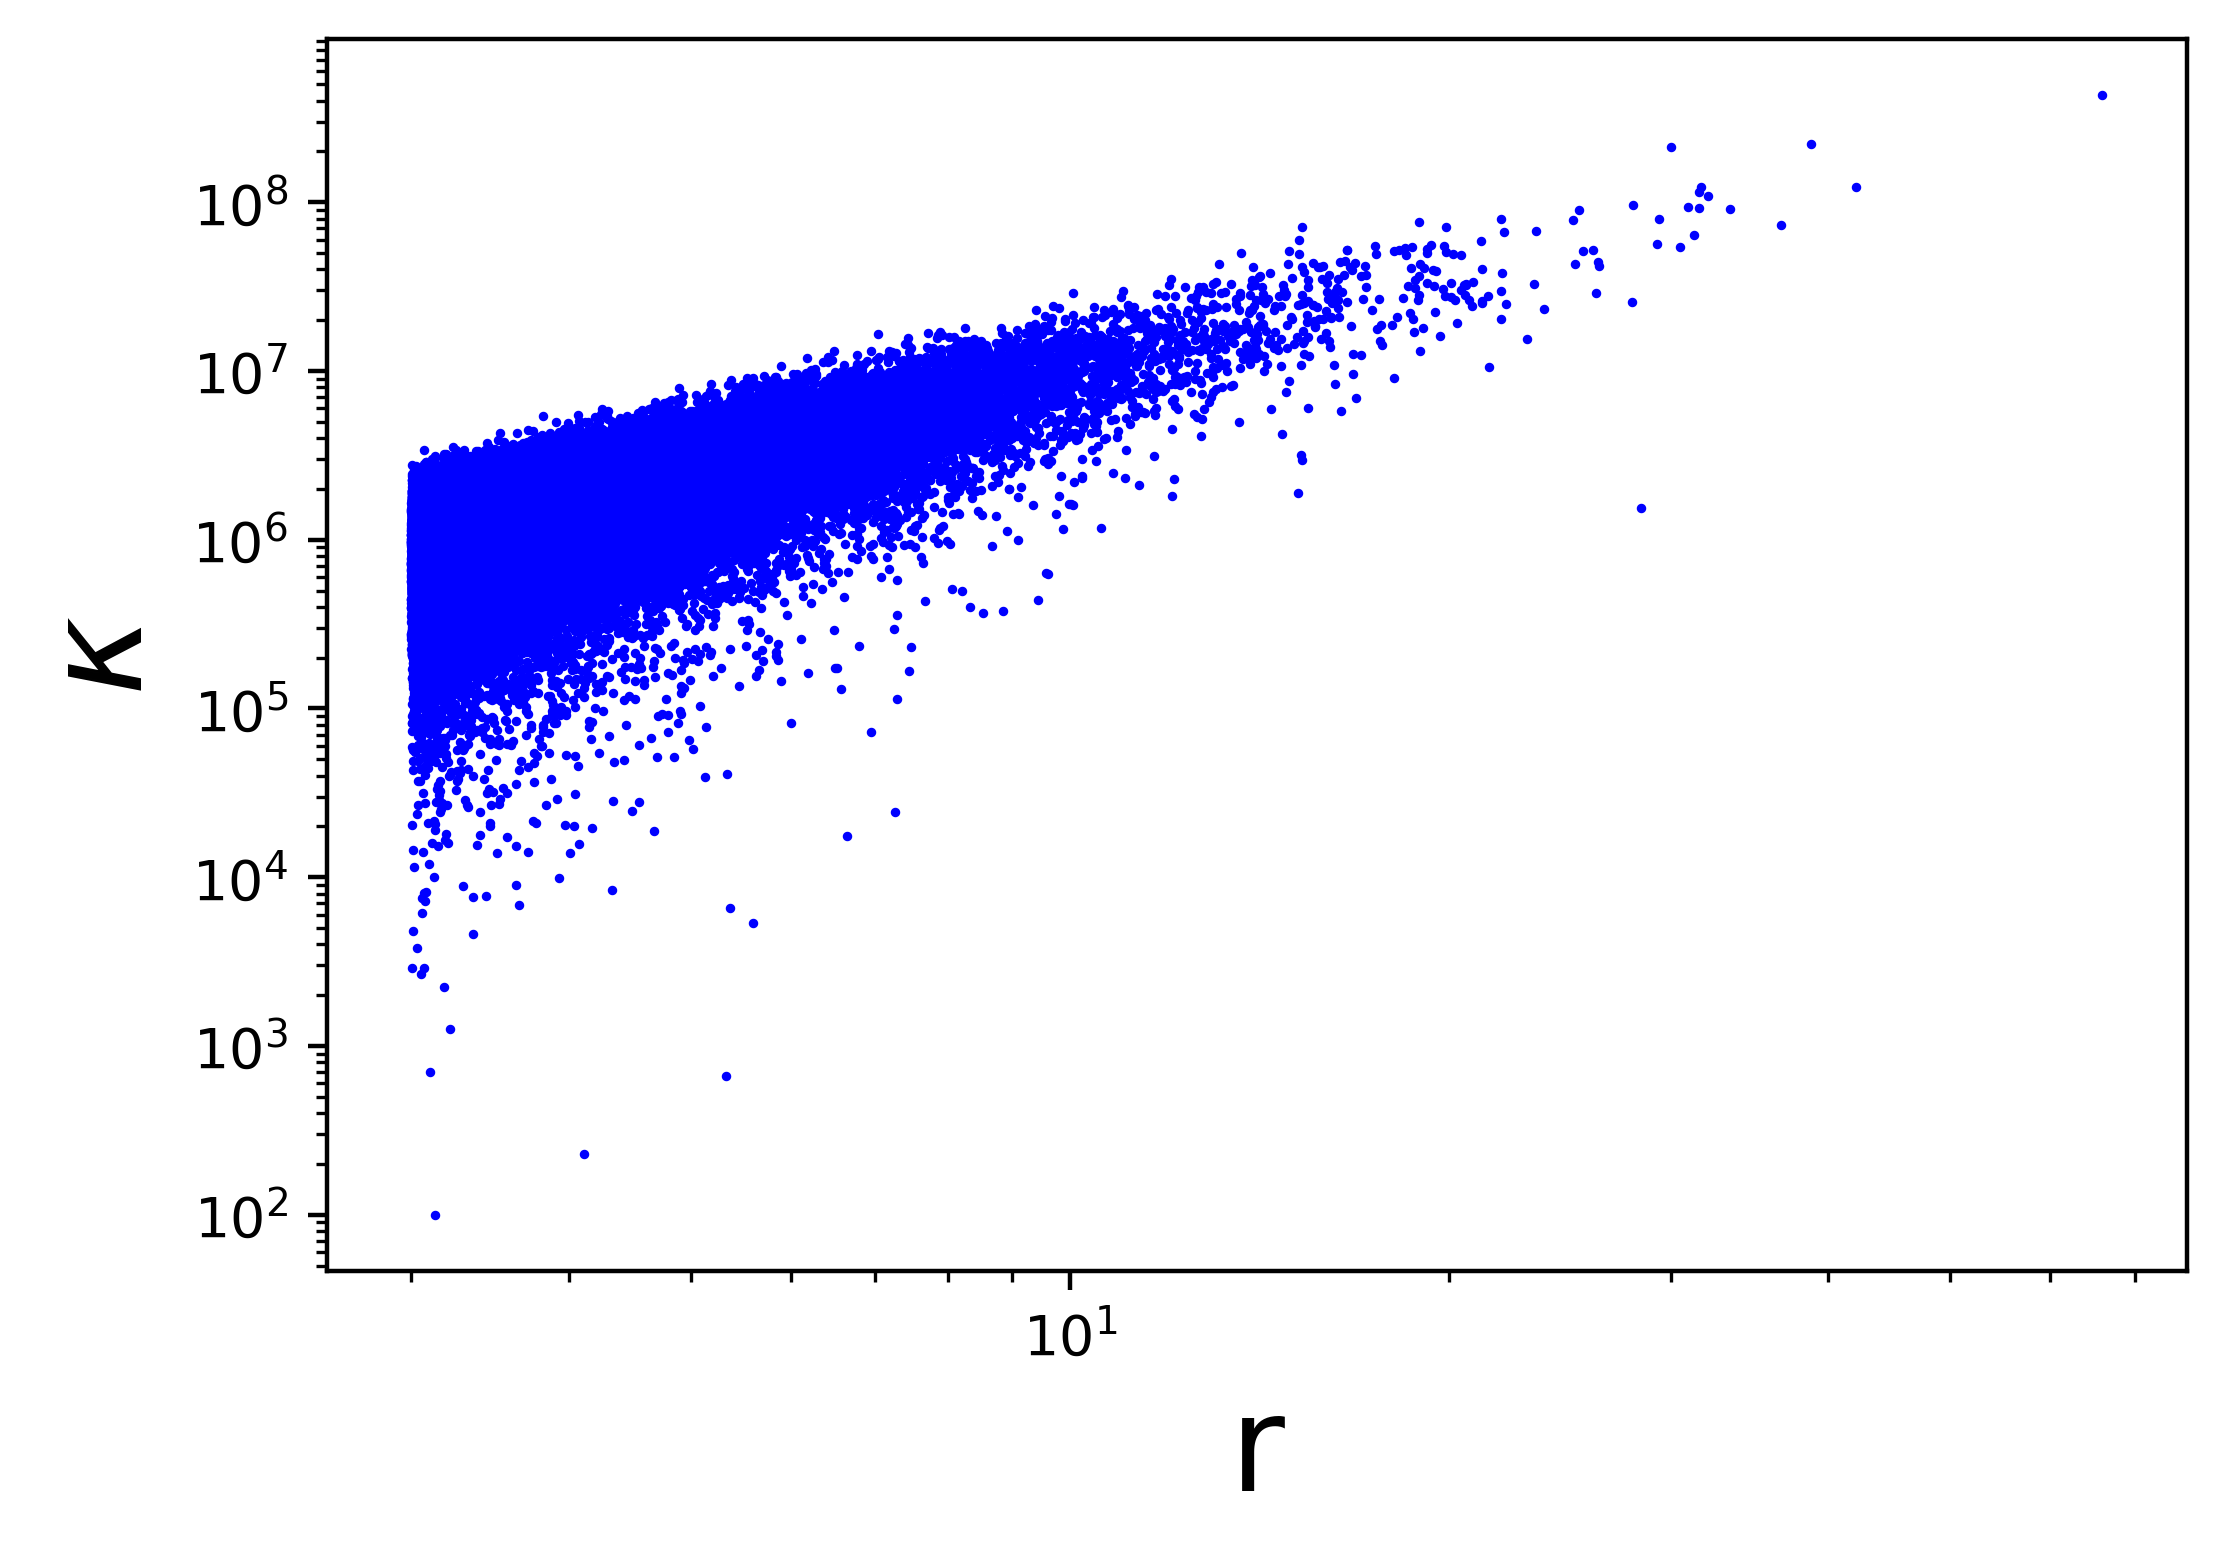

In [18]:
plt.figure(figsize=(6, 4), dpi=dpi)

# Sampled scatterplot
plt.scatter(
    df.radius,
    df.lifespan,
    c="blue",
    s=.5,
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("$\\kappa$", fontsize=font_size)

plt.savefig(f"figures/example_lifetimes_scatter.png", bbox_inches="tight")
plt.show()

In [19]:
model = smf.negativebinomial(data=df, formula="lifespan ~ 1 + np.log(radius)").fit(maxiter=1000, method="BFGS", cov_type="HC0")
print(model.summary())

Optimization terminated successfully.
         Current function value: 14.812476
         Iterations: 8
         Function evaluations: 11
         Gradient evaluations: 11
                     NegativeBinomial Regression Results                      
Dep. Variable:               lifespan   No. Observations:               100000
Model:               NegativeBinomial   Df Residuals:                    99998
Method:                           MLE   Df Model:                            1
Date:                Sat, 11 Jan 2025   Pseudo R-squ.:                 0.03308
Time:                        17:28:55   Log-Likelihood:            -1.4812e+06
converged:                       True   LL-Null:                   -1.5319e+06
Covariance Type:                  HC0   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         11.5029     

In [22]:
# Dispersion statistic
np.sum(model.resid_pearson**2) / model.df_resid

np.float64(0.8890806383397498)